# Create edgelist for network analysis of co-occuring words in newspaper titles 

In [8]:
import numpy as np 
import re
import itertools
from itertools import combinations
import networkx as nx
import pandas as pd
#from scipy.spatial import distance
import matplotlib.pyplot as plt
#%matplotlib inline
from collections import defaultdict
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
#nltk.download('punkt')
#!pip install spacy
import spacy
#nlp = spacy.load('en_core_web_sm')
from spacy.language import Language
#save a sample of list
from random import sample
import operator
from itertools import count

In [2]:
data = pd.read_csv('preprocessed.csv', encoding='utf-8')
#data

In [3]:
#get a sample 
df2 = data.sample(500)

In [4]:
#download spacy en_core_web_sm if not downloaded alreadt
#!python -m spacy download en_core_web_sm
#load spacy model
nlp = spacy.load("en_core_web_sm") 


#add extra words you want to exclude
nlp.Defaults.stop_words.add('advertisement') 
nlp.Defaults.stop_words.add('s')
nlp.Defaults.stop_words.add('placeholder')
nlp.Defaults.stop_words.add('t')

print(nlp.Defaults.stop_words)
stopwords = nlp.Defaults.stop_words

{'’s', "'s", 'thereupon', 'at', 'itself', 'he', 'some', 'all', 'about', 'less', 'everyone', 'front', 'me', 'side', 'beyond', 'next', '’ll', 'only', 'again', 'around', 'indeed', 'when', 'afterwards', 'any', 'how', 'using', '’re', 'something', 'give', 'mostly', 't', 'either', 'him', 'twenty', 'often', "'m", 'whatever', 'nothing', "'re", 'throughout', 'never', 'be', 'has', 'herein', 'on', 'namely', 'hereupon', 'down', 'hence', 'everything', 'over', 'bottom', 'advertisement', 'who', 'per', 'i', 'others', 'towards', 'which', 'somehow', 'due', 'moreover', 'cannot', 'regarding', 'else', 'several', 'name', 'whither', 'off', 'under', 'among', 'will', 'beside', 'until', 'would', 'not', 'a', '‘s', 'therefore', 'become', 'nobody', 'you', 'go', 'amount', 'if', 'yours', 'just', 'someone', 'made', 'really', 'quite', 'hereafter', 'an', 'my', 'mine', 'for', 'already', 'wherein', 'did', 'the', 'serious', 'were', 'meanwhile', 'but', "'ve", 'thus', 'do', 'without', 'see', 'and', 's', 'against', 'can', 'be

In [5]:
#con only do this once
#this makes sure that the tokenization considers entities

class EntityRetokenizeComponent:
    def __init__(self, nlp):
        pass

    def __call__(self, doc):
        with doc.retokenize() as retokenizer:
            for ent in doc.ents:
                retokenizer.merge(doc[ent.start:ent.end], attrs={"LEMMA": str(doc[ent.start:ent.end])})
        return doc

@Language.factory("entity_retokenizer_component")
def create_entity_retokenizer_component(nlp, name):
    return EntityRetokenizeComponent(nlp)

nlp = spacy.load("en_core_web_sm")  
nlp.add_pipe("entity_retokenizer_component", name='merge_phrases', last=True)


#rule to prevent spacy from splitting ID into I & D
nlp.tokenizer.rules = {key: value for key, value in nlp.tokenizer.rules.items() if key != "id"}

In [ ]:
#test out the updated tokenizer
#doc = "German Chancellor Angela Merkel and US President Barack Obama (Donald Trump as id president-elect') converse in the Oval Office inside the White House in Washington, D.C."
#tokened_text = [token.text for token in nlp(doc)]
#tokened_text

In [9]:
#preprocess the text 
def preprocessing(corpus):
    '''this function preprocesses text. 
    It creates tokens, lowercases, 
    checks if str elements are actual words, 
    and then appends them to a list of clean '''
    clean_text = []

    for row in corpus:
        #tokens = [token.text for token in nlp(row)] spacy
        #word tokenize
        tokens = word_tokenize(row) #nltk
        #lowercase
        tokens = [token.lower() for token in tokens]
        # isword
        tokens = [token for token in tokens if token.isalpha()]
        #remove stopwords
        tokens = [word for word in tokens if not word in nlp.Defaults.stop_words]
        clean_sentence = ''
        clean_sentence = ' '.join(token for token in tokens)
        clean_text.append(clean_sentence)
       
    return clean_text
 

In [10]:
#take a sample to test out function
df2['clean_text'] = preprocessing(df2.astype(str)['maintext'])

In [11]:
#check if shiftwords in str
#read shifterator words
#we will make a co-occurance nwtwork of only texts that contain these classified words

shift_words = open('shiftwords_2.txt').read().splitlines()
df2['contains_shift'] = df2['clean_text'].str.contains('|'.join(shift_words)) #True or False based on condition
df2

,date,maintext,title,source,media_name,ideology,Congress,text,clean_text,contains_shift
1234,2019/03/06,The Washington Post<U+0091>s fact checker gave...,WaPo Gives Clinton <U+0091>Four Pinocchios<U+0...,https://freebeacon.com/politics/wapo-gives-cli...,Free Beacon,right,116th,washington post<u+0091>s fact checker gave two...,washington post fact checker gave failed presi...,True
549,2017/03/25,"JEFFERSON CITY, Mo. (AP) - At the halfway poin...",Missouri lawmakers return to pro-business agen...,http://www.washingtontimes.com/news/2017/mar/2...,Washington Times,right,115th,"jefferson city, mo. (ap) - halfway point 2017 ...",jefferson city mo ap halfway point session mis...,True
3974,2018/09/12,This is part of a series on what is at stake i...,Make Voting Easier in New York,C:/Users/analo/OneDrive - University of Glasgo...,The New York Times,left,115th,part series stake york<u+0092>s primary electi...,series stake new york primary elections thursd...,True
3756,2020/09/10,The president claims he is a champion of Black...,"In Encounters With Black Leaders, Trump Has Ch...",C:/Users/analo/OneDrive - University of Glasgo...,The New York Times,left,116th,president claims champion black americans. wor...,president claims champion black americans trie...,True
2935,2021/06/28,"Three cheers for the Senate filibuster rule, w...",Failure of <U+0091>For the People Act<U+0092> ...,https://nypost.com/2021/06/27/failure-of-for-t...,NY Post,right,117th,"cheers senate filibuster rule, requires 60 vot...",cheers senate filibuster rule requires votes b...,True
...,...,...,...,...,...,...,...,...,...,...
3517,2020/07/31,Barack Obama has spoken candidly about Preside...,"Privately Slamming Trump, Obama Pulls In Over ...",C:/Users/analo/OneDrive - University of Glasgo...,The New York Times,left,116th,barack obama spoken candidly president trump p...,barack obama spoken candidly president trump p...,True
427,2013/06/26,"As weeks go for the Supreme Court, this one wa...",Supreme Court Rulings on Marriage and Voting R...,http://www.huffingtonpost.com/michael-sargeant...,Huffington Post,left,113th,"weeks supreme_court, historic. first, supreme_...",weeks supreme court truly historic supreme cou...,True
142,2013/08/26,Placeholder while article actions load\r\r\nWe...,Wonkbook: <U+0091>The biggest bubble of them a...,http://www.washingtonpost.com/blogs/ezra-klein...,Washington Post,left,113th,"placeholder article actions load wonkbook, ezr...",article actions load welcome wonkbook ezra kle...,True
1782,2020/09/18,Placeholder while article actions load\r\r\nSt...,What parents need to know about recent movies,https://www.washingtonpost.com/goingoutguide/m...,Washington Post,left,116th,placeholder article actions load streaming wp ...,article actions load streaming wp experience c...,True


In [12]:
#drop all rows that do not contain any of the shift words
df2 = df2.drop(df2[df2.contains_shift == False].index) 

In [ ]:
#clean title/text using the function on the whole dataset
#data['clean_title'] = preprocessing(data.astype(str)['title']) 

### Create edge list from text for igraph (this can take a long time ...)

In [13]:
texts = df2.clean_text.to_list()
for sentence in texts:
    tokenized = [token.text for token in nlp(sentence)]      
    edgelist = defaultdict(int)
    for node1, node2 in combinations(tokenized, 2):
        edgelist[(node1,node2)]+=1

#Save edgelist as .txt file
with open("edgelist1.txt", mode='w') as f:
    for k, v in edgelist.items():
        f.write(f"{k[0]},{k[1]},{v}\n")

In [ ]:
#len(edgelist)

In [29]:
#we sort the edglist by value so that we can see what is the maximum which can inform us about where to make the cut
sorted_d = sorted(edgelist.items(), key=operator.itemgetter(1), reverse = True)
#print the list from top down to get an idea about how frequent are the occurances to be able to filter later on
sorted_d

[(('said', 'elections'), 112),
 (('report', 'elections'), 96),
 (('report', 'said'), 88),
 (('said', 'voter'), 86),
 (('voting', 'elections'), 81),
 (('report', 'voter'), 79),
 (('said', 'said'), 78),
 (('report', 'voting'), 72),
 (('said', 'voting'), 72),
 (('voting', 'voter'), 67),
 (('russian', 'elections'), 63),
 (('interference', 'elections'), 61),
 (('said', 'russian'), 60),
 (('report', 'russian'), 58),
 (('said', 'social'), 58),
 (('voting', 'said'), 58),
 (('russian', 'said'), 57),
 (('voter', 'elections'), 57),
 (('black', 'elections'), 55),
 (('report', 'report'), 55),
 (('said', 'report'), 55),
 (('said', 'news'), 54),
 (('black', 'said'), 53),
 (('russian', 'voter'), 51),
 (('report', 'social'), 49),
 (('report', 'news'), 48),
 (('interference', 'said'), 48),
 (('said', 'internet'), 48),
 (('voters', 'elections'), 48),
 (('russian', 'voting'), 47),
 (('interference', 'voter'), 47),
 (('said', 'voters'), 47),
 (('report', 'interference'), 45),
 (('report', 'voters'), 45),
 

In [30]:
#filter edges based on weight (aka the frequency of co-occurance) 
filtered = {k: v for k, v in edgelist.items() if v > 10}
#len(filtered)

In [31]:
#save filtered edgelist for network analysis
with open("filtered_3.txt", mode='w') as f:
    for k, v in filtered.items():
        f.write(f"{k[0]},{k[1]},{v}\n")

# Network analysis 

In [32]:
#create graph object
G = nx.read_weighted_edgelist('filtered_3.txt', delimiter=',')
#get edge list data
#G.edges.data()
#G.remove_nodes_from(list(nx.isolates(G)))

#### Add node attributes from shifterator scores (see other notebook)

In [33]:
node_attr = pd.read_csv('shifterator_2.csv' )

In [34]:
#make all numbers absolute so that they can be used for node sizes
node_attr['score'] = node_attr['score'].abs()

In [35]:
#node_attr
#create dict that contains node attributes to be merged with the network graph (G) later on 
node_attributes = node_attr.to_dict('records')

In [36]:
#create node2attributemap to be merged with nodes 
node2attributemap = {n['word']: {'leaning': n['left_right'], 'score':n['score']} for n in node_attributes}
# print(node2attributemap)
#set node attributes to the Graph
nx.set_node_attributes(G, node2attributemap)

In [37]:
#we see that we managed to add node attributes to the graph object
G.nodes.data()

NodeDataView({'russian': {'leaning': 'right', 'score': 0.000313441403407}, 'presidential': {'leaning': 'left', 'score': 0.0014708957334581}, 'election': {'leaning': 'right', 'score': 0.0008919630952771}, 'black': {'leaning': 'left', 'score': 0.0015513826526627}, 'report': {'leaning': 'right', 'score': 0.0003519277239608}, 'rights': {'leaning': 'left', 'score': 0.0032534640193015}, 'interference': {'leaning': 'left', 'score': 8.112514751762269e-05}, 'said': {'leaning': 'left', 'score': 0.0013085439841424}, 'voting': {'leaning': 'left', 'score': 0.0029488588560597}, 'including': {'leaning': 'right', 'score': 2.96915093910357e-06}, 'domestic': {'leaning': 'right', 'score': 0.0001317606319067}, 'states': {'leaning': 'left', 'score': 0.0006790802855195}, 'restrictions': {'leaning': 'left', 'score': 0.0009194387245269}, 'voter': {'leaning': 'right', 'score': 0.0007522584606695}, 'identification': {'leaning': 'right', 'score': 0.0002017789210582}, 'laws': {'leaning': 'right', 'score': 0.00061

In [38]:
size_map = nx.get_node_attributes(G, "score")
size = list(size_map.values())

In [25]:
#size_map

{'russian': 0.000313441403407,
 'exploit': 1.0948937957012572e-06,
 'racial': 0.0008180051938291,
 'presidential': 0.0014708957334581,
 'election': 0.0008919630952771,
 'found': 0.0002334021153742,
 'country': 0.0007192645368521,
 'black': 0.0015513826526627,
 'vote': 0.0007408734515431,
 'report': 0.0003519277239608,
 'monday': 0.0001444415330561,
 'state': 0.0017716618347265,
 'civil': 0.0017351126961619,
 'rights': 0.0032534640193015,
 'interference': 8.112514751762269e-05,
 'said': 0.0013085439841424,
 'voting': 0.0029488588560597,
 'including': 2.96915093910357e-06,
 'domestic': 0.0001317606319067,
 'politicians': 0.0001854537768046,
 'states': 0.0006790802855195,
 'restrictions': 0.0009194387245269,
 'gotten': 9.241460011805429e-06,
 'worse': 0.0003766548629205,
 'changes': 0.0002636135360873,
 'voter': 0.0007522584606695,
 'identification': 0.0002017789210582,
 'laws': 0.0006166906710735,
 'voters': 0.0020187783418131,
 'ballots': 0.0010353451162506,
 'research': 8.6808854181412

### The reason why it doesn't work with the full list is that shifterator was using nltk tokenizer which ignores entities. Once that is fixed we will be good to go. I tried some things not sure why it doesn't works completely. 

### Probably has to do something with using the exception condition for spacy. 

#### works alright with a NLTK tokenizer as long as the shifterator stuff is also using the same exact preprocessing method.

#### Draw graph

ValueError: s must be a scalar, or float array-like with the same size as x and y

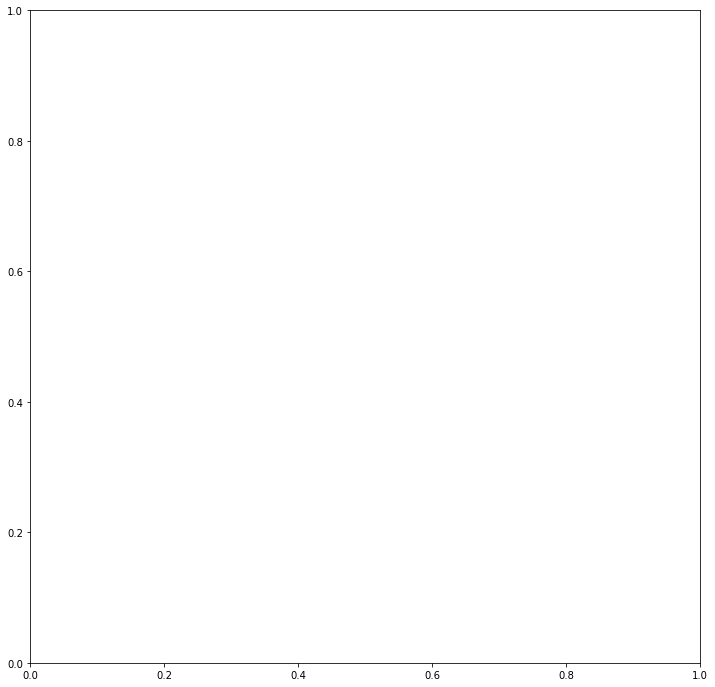

In [39]:
fig, ax = plt.subplots(figsize=(12, 12))
pos = nx.spring_layout(G, k=1)

#need a size map to adjust node size based on the shifterator score
#again these were made absolute so that their magnitude can be compared on the network graph
size_map = nx.get_node_attributes(G, "score")
size = list(size_map.values())


#need a color map to adjust node color based on the left vs. right leaning of the shifterator score 
#if the node attribute leaning is 'left' then we set the color blue
#if the node attribute leaning is 'right' then we set the color red
color_map = nx.get_node_attributes(G, 'leaning')
for key in color_map:
    if color_map[key]== 'left':
        color_map[key]= 'blue'
    if color_map[key]== 'right':
        color_map[key]= 'red'
partisan_cols = [color_map.get(node) for node in G.nodes()]
#partisan_cols

#scaling factor for edge weights
edges = G.edges()
weights = nx.get_edge_attributes(G, "weight")
scaling_factor = 0.04 # to emphasise differences 
alphas = [weights[edge] * scaling_factor for edge in edges]

# Plot networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width = alphas,
                 edge_color='grey',
                 with_labels = False,
                 ax=ax, alpha = 0.5,
                node_color = partisan_cols,
                node_size = [x * 1000000 for x in size])



#Create offset labels 
#basically we create labels with white backround and align them horizontally
#we also specify how far the labels should be from the nodes

for key, value in pos.items():
    x, y = value[0]+.10, value[1]+.020
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='white', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
#we use tight layout to fit the graph inside the borders
plt.tight_layout()